In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

In [3]:
# Parameters
gOP = 2 * np.pi # Optical pumping rate
W_R = 0.01 * gOP # Coupling strength in terms of the Rabi frequency
w_L = gOP * 2e2 # Etalon Larmor frequency
gL = 2 * w_L  # Cavity linewidth
gT = 1.0 * gOP # Thermal relaxation rate
delta = np.linspace(-6*w_L,6*w_L,320)# Microwave detuning

In [4]:
# Initialize the quantum system

states = []  # list with the basis states
for i in np.arange(8):
    states.append(basis(8, i))

psi1_1 = states[0] # (1,-1) ground state
psi10 = states[1] # (1,0) ground state
psi11 = states[2] # (1,+1)ground state
psi2_2 = states[3] # (2,-2)ground state
psi2_1 = states[4] # (2,-1)ground state
psi20 = states[5] # (2,0)ground state
psi21 = states[6] # (2,+1)ground state
psi22 = states[7] # (2,+2)ground state

# Projector operators onto the basis states
P = []
for psi in states:
    P.append(ket2dm(psi))

# Relaxation

We model the optical pumping as relaxation from F=2 to F=1 at the same rate for all sublevels. The process is described by the following collapse operator:
$$    \hat{L}_{\rm OP}(m_{\rm F},\widetilde{m}_{\rm F})=\sqrt{\Gamma_{\rm OP}}|F=1,m_{\rm F}\rangle\langle F=2,\widetilde{m}_{\rm F}|. $$

For the thermal relaxation, we assume that each Zeeman sublevel mixes with every other sublevel at the same rate:
$$     \hat{L}_{\rm}=\sqrt{\Gamma_{\rm th}}|i\rangle \langle j|,$$



In [5]:
# Collapse operators

c_ops = [] # List with collapse operators

# Optical pumping relaxation
for psi1 in states[0:3]:
    for psi2 in states[3:]:
        c_ops.append(np.sqrt(gOP) * psi1 * psi2.dag())

# Thermal relaxation between the Zeeman states
for i in np.arange(8):
    for j in np.arange(8):
        if i != j:
            c_ops.append(np.sqrt(gT) * states[i] * states[j].dag())

# Hmiltonian

The Hamiltonian is given in the rotating-wave approximation

## Diagonal part

The diagonal part of the Hamiltonian is given by
$$\hat{H}_0 = \hbar\sum_{m_F}\left(\dfrac{\delta}{2}-m_{\rm F}\omega_{\rm L}\right)| F=1,m_{\rm F}\rangle\langle F=1,m_{\rm F}|+\hbar\sum_{\widetilde{m}_{\rm F}}\left(\widetilde{m}_{\rm F}\omega_{\rm L}-\dfrac{\delta}{2}\right)|F=2,\widetilde{m}_{\rm F}\rangle\langle F=2,\widetilde{m}_{\rm F}|,$$

where $\delta$ is the microave detuning from the clock transition, and $\omega_L$ is the Larmor frequency.

In [6]:
def H_d(d, wL):
    """Diagonal part of the Hamiltonian as a function of detuning d form the clock transition and the Larmor frequency"""
    H = 0*qeye(len(states))
    H += (wL+0.5*d)*P[0]
    H += 0.5*d*P[1]
    H += (-wL+0.5*d)*P[2]
    H += -(0.5*d+2*wL)*P[3]
    H += -(0.5*d+wL)*P[4]
    H += -0.5*d*P[5]
    H += -(0.5*d-wL)*P[6]
    H += -(0.5*d-2*wL)*P[7]
    return H

## Interaction Hamiltonian (off-diagonal)

The interacion Hamiltonian is given by

$$\hat{V}=\dfrac{\hbar}{2}\sum_{\widetilde{m}_{\rm F}}\sum_{m_{\rm F}}\Omega_{m_{\rm F},\widetilde{m}_{\rm F}}|F=1,m_{\rm F}\rangle\langle F=2,\widetilde{m}_{\rm F}|+ {\rm h.c.}.$$

For the $\pi$-transitions, the coupling strength is given by
$$\Omega_{m_{\rm F}m_{\rm F}}=\Omega_{0}\cos\theta S_{m_{\rm F}m_{\rm F}}\sqrt{L(\delta_{m_{\rm F}m_{\rm F}})}$$,
where $\Omega_0$ is the full Rabi frequency,  $\theta$ is the angle between the microwave field and the DC field, S is the transition strength ('Sl' in the code), and $L$ is the cavity line profile.

For the $\sigma$-transitions, the expression is the same, except $\cos\theta$ is replaced with $\sin\theta$.


In [7]:
def L(f, g):
    """Cavity line-width"""
    if g == 0:
        return 1 # For simplicity, I set this condition fot the case when there is no cavity
    return g**2/(g**2+f**2)

def So(W_R, theta, wL):
    """Coupling strength for sigma transitions with cavity"""
    transition_strength = np.array([0.5*np.sqrt(3),  0.25*np.sqrt(2), 0.25*np.sqrt(6), 0.25*np.sqrt(6), 0.25*np.sqrt(2),  0.5*np.sqrt(3)])
    if wL == 0:
        return 0 # To avoid double counting in the degenerate case
    return transition_strength * W_R * np.sin(theta) * np.sqrt(L(np.array([-3,-1,-1,1,1,3])*wL,gL))

def Sl(W_R, theta, wL):
    """Coupling strength for pi transitions with cavity"""
    transition_strength = np.array([0.5*np.sqrt(3), 1, 0.5*np.sqrt(3)])
    return transition_strength * W_R * np.cos(theta) * np.sqrt(L(np.array([-2, 0, 2])*wL,gL))

def V(W_R, theta, wL):
    """Interaction part of the Hamiltonian as a function of the Larmor frequency"""
    V_l = 0*qeye(len(states))
    V_o = 0*qeye(len(states))

    W_par = W_R * np.cos(theta)
    W_ort = W_R * np.sin(theta)

    for i in range(3):
        V_l += 0.5*Sl(W_R, theta, wL)[i]*(states[i]*states[i+4].dag())+0.5*Sl(W_R, theta, wL)[i]*(states[i]*states[i+4].dag()).dag() # Pi transition
        V_o += 0.5*So(W_R, theta, wL)[2*i]*(states[i]*states[i+3].dag())+0.5*So(W_R, theta, wL)[2*i]*(states[i]*states[i+3].dag()).dag() # Sigma- transitions
        V_o += 0.5*So(W_R, theta, wL)[2*i+1]*(states[i]*states[i+5].dag())+0.5*So(W_R, theta, wL)[2*i+1]*(states[i]*states[i+5].dag()).dag() # Sigma+ transition
    return V_o+V_l

## Total Hamiltonian

In [8]:
def H(d, W_R, theta, wL):
    return H_d(d, wL) + V(W_R, theta, wL)

# Finding steady state

We find the steady-state population by solving the Lindblad equation
$$    \dfrac{d}{dt}\hat{\rho}=-\dfrac{i}{\hbar}\left[\hat{H},\hat{\rho}\right]+\dfrac{1}{2}\sum_{n} \left(2\hat{L}_n\hat{\rho} \hat{L}_n^{\dagger}-\hat{\rho}\hat{L}_n^{\dagger}\hat{L}_n-\hat{L}_n^{\dagger}\hat{L}_n\hat{\rho}\right).$$

In [9]:
theta = np.pi * 0.5

ss_1 = [] # Steady-state population in F=1, mF=-1
ss0 = [] # Steady-state population in F=1, mF=0
ss1 = [] # Steady-state population in F=1, mF=1
for d in delta:
    ss = steadystate(H(d, W_R, theta, w_L), c_ops, drop_tol=1e-10) #steady state
    ss_1.append(expect(P[0], ss)) # Steady-state populations of psi1
    ss0.append(expect(P[1], ss)) # Steady-state populations of psi2
    ss1.append(expect(P[2], ss)) # Steady-state populations of psi3

# Convert to arrays
ss_1, ss0, ss1 = map(np.array, (ss_1, ss0, ss1))
rho = ss_1 + ss0 + ss1 # Total population of the F=1 ground state

Text(0, 0.5, 'Population')

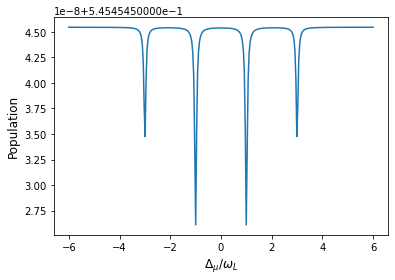

In [10]:
fig, ax = plt.subplots()
ax.plot(delta/w_L, rho)
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$',fontsize=12)
ax.set_ylabel('Population',fontsize=12)

# Calculate absorption coefficient

In [11]:
# Fractions of atoms in the velocity classes resonant with different transitions
c = 2.99792458e8 # Speed of light in m/s
f = 384.230484468562e12-302.073888e6 # Optical transition frequency in Hz
kB = 1.380650324e-23 # Boltzmann constant in  J/K
T = 300 # Vapor temperature in K
m = 87*1.6605387313e-27 # 87Rb mass in kg
v = np.sqrt(2*kB*T/m) # Most probable thermal speed in m/s

N0 = 1. # The ensemble fraction in  F'=0
N1 = N0 * np.exp(-((72.2e6*c)/(f*v))**2)#ensemble fraction in F'=1
N2 = N0 * np.exp(-((72.2e6+156.9e6)*c/(f*v))**2)#ensemble fraction in F'=2

# Total sigma+ absorption as a function of sublevel populations
def Asp(P_1, P0, P1):
    A = P_1*(N0*1./6+N1*5./24+N2*1./24)+P0*(N0*0+N1*5./24+N2/8)+P1*N2/4
    return A

# Same for pi
def Api(P_1, P0, P1):
    A = P_1*(N0*0+N1*5./24+N2*1./8)+P0*(N0/6+N1*0+N2/6)+P1*(N0*0+N1*5./24+N2*1./8)
    return A

# Same for sigma-
def Asm(P_1, P0, P1):
    A=P1*(N0*1./6+N1*5./24+N2*1./24)+P0*(N0*0+N1*5./24+N2/8)+P_1*N2/4
    return A

# Total absorption for light split between polarization components as:  π : 0.5,  σ+ :0.25,  σ− :0.25
def A(P_1, P0, P1):
    return 0.5*Api(P_1,P0,P1)+0.25*Asp(P_1,P0,P1)+0.25*Asm(P_1,P0,P1)

Text(0.5, 1.0, '$0.25\\sigma^{+}$')

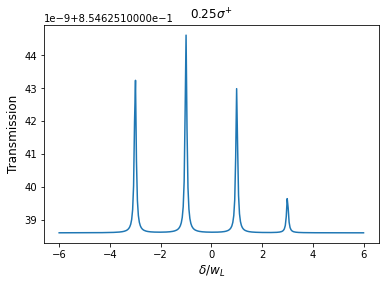

In [12]:
# Plot transmission for sigma+ polarization
alpha_p = Asp(ss_1,ss0,ss1)
Tsigma = 1-alpha_p
fig, ax = plt.subplots()
ax.plot(delta/w_L, Tsigma,label=r'$-1$')
ax.set_xlabel(r'$\delta/w_L$',fontsize=12)
ax.set_ylabel(r'Transmission',fontsize=12)
ax.set_title(r'$0.25\sigma^{+}$')

Text(0, 0.5, 'Transmission')

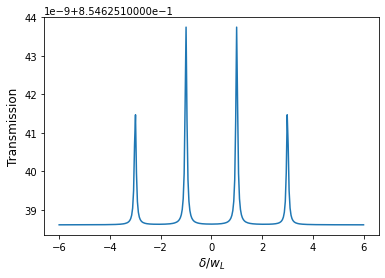

In [13]:
# Plot transmission for the mixed polarization
alpha_mixed = A(ss_1,ss0,ss1)
Tmixed = 1-alpha_mixed
fig, ax = plt.subplots()
ax.plot(delta/w_L,Tmixed,label=r'$-1$')
ax.set_xlabel(r'$\delta/w_L$',fontsize=12)
ax.set_ylabel(r'Transmission',fontsize=12)